# Introduction

As the world becomes more digitally connected, social media platforms like Twitter have evolved into crucial information channels during emergencies. This project aims to harness this data resource for the betterment of disaster relief efforts and news reporting. We will utilize the possibilites of train language model transformer such as BERT to classify the tweets into class 0 (not related to a real-life disaster) and 1 (related to a real-life disaster).

# Data Preprocessing

In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.utils import to_categorical
import numpy as np
import re

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# Load data
train_data = pd.read_csv('/content/drive/MyDrive/trainD.csv', sep=',', header=0)

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Check the number of missing data.

In [15]:
missing_data = train_data.isnull().sum()
print(missing_data)

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


Let's have a look at the initial data.

In [8]:
train_data.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


There is a lot of noises or unexpected characters in the data such as hashtags (#). This will have a negative effect on our text classification task. We will make a preprocess_text function as below to solve this problem.

In [9]:
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r"http\S|www\S|https\S", '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove emoji
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove hashtags
    text = re.sub(r'\#\w+', '', text)
    # Remove quotation marks
    text = re.sub(r'\"', '', text)
    # Remove single quotation marks
    text = re.sub(r"\'", '', text)
    # Remove extra white spaces
    text = re.sub(r'[\r|\n|\r\n]+', ' ', text)
    # To lower case
    text = text.lower()
    return text

In [10]:
# Combine text and keyword columns
train_data['text'] = train_data['text'] + ' ' + train_data['keyword'].fillna('')

In [11]:
# Preprocessing
train_data['text'] = train_data['text'].apply(preprocess_text)

Let's take a look the a data after preprocessing. Now it looks better!

In [12]:
train_data.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this may allah fo...,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,"13,000 people receive evacuation orders in ca...",1
4,7,NaN,NaN,just got sent this photo from ruby as smoke f...,1
5,8,NaN,NaN,update => california hwy. 20 closed in both d...,1
6,10,NaN,NaN,heavy rain causes flash flooding of streets ...,1
7,13,NaN,NaN,im on top of the hill and i can see a fire in ...,1
8,14,NaN,NaN,theres an emergency evacuation happening now i...,1
9,15,NaN,NaN,im afraid that the tornado is coming to our ar...,1


A visualization of frequency of labels

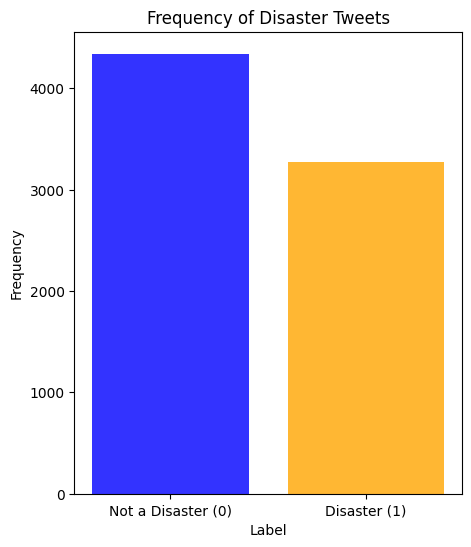

In [14]:
import matplotlib.pyplot as plt

# Assume 'train_data' is your DataFrame and 'target' is your target column
label_counts = train_data['target'].value_counts()

plt.figure(figsize=(5, 6))
plt.bar(label_counts.index, label_counts.values, color=['blue', 'orange'], alpha=0.8)
plt.title('Frequency of Disaster Tweets')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Not a Disaster (0)', 'Disaster (1)'])
plt.show()

The visualization above showed that there is no evidence of class imbalance, we can proceed with our models.

# BERT Language Model

BERT is a transformers-based model that has undergone pretraining on an extensive collection of English data in a self-supervised manner.

This indicates that the raw texts were used for pretraining without any human intervention or labeling, thus enabling the use of a vast amount of publicly accessible data. The model employs an automatic process to derive inputs and labels from these texts.

This internal representation can then be harnessed to derive features that are valuable for downstream tasks. For example, if you possess a dataset of labeled sentences, you can utilize the features generated by the BERT model as inputs to train a typical classifier.

In [15]:
# Load the BERT tokenizer and language model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

# RNN with LSTM

I will experiment with 3 different RNN architectures: firstly with LSTM, secondly with GRU and lastly with Bidirectional LSTM.

For our project, we will use word embeddings with 'bert-base-uncased'.

### Model Training

In [20]:
from tensorflow.keras.layers import Input, LSTM, Dense, Masking

In [16]:
# Tokenize the data
input_ids = tokenizer(train_data['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors='tf')

In [17]:
# Prepare the data
X_train = {'input_ids': input_ids['input_ids'], 'attention_mask': input_ids['attention_mask']}
y_train = train_data['target'].values

In [18]:
input_ids_in = Input(shape=(78,), name='input_ids', dtype='int32')
mask_in = Input(shape=(78,), name='attention_mask', dtype='int32')

In [19]:
# We access the transformer model within our bert_model
embedding_layer = bert_model.layers[0]
embeddings = embedding_layer(input_ids_in, attention_mask=mask_in)[0]

In [21]:
# Define the model architecture
def build_model():
    embeddings = bert_model(input_ids_in, attention_mask=mask_in)[0]
    rnn_input = Masking(mask_value=0)(embeddings)
    rnn_output = LSTM(units=64)(rnn_input)
    output = Dense(units=1, activation='sigmoid')(rnn_output)
    model = Model(inputs=[input_ids_in, mask_in], outputs=output)
    return model

In [23]:
# Build the model
modelLSTM = build_model()
modelLSTM.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
modelLSTM.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 78)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 78)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 78,                                          

In [25]:
# Train the model
modelLSTM.fit(X_train, y_train, epochs=6, verbose=1)

Epoch 1/6


238/238 [==============================] - 90s 160ms/step - loss: 0.4543 - accuracy: 0.7921
Epoch 2/6
238/238 [==============================] - 23s 95ms/step - loss: 0.3503 - accuracy: 0.8568
Epoch 3/6
238/238 [==============================] - 21s 87ms/step - loss: 0.2851 - accuracy: 0.8882
Epoch 4/6
238/238 [==============================] - 19s 82ms/step - loss: 0.2211 - accuracy: 0.9187
Epoch 5/6
238/238 [==============================] - 20s 81ms/step - loss: 0.1682 - accuracy: 0.9384
Epoch 6/6
238/238 [==============================] - 19s 80ms/step - loss: 0.1299 - accuracy: 0.9513


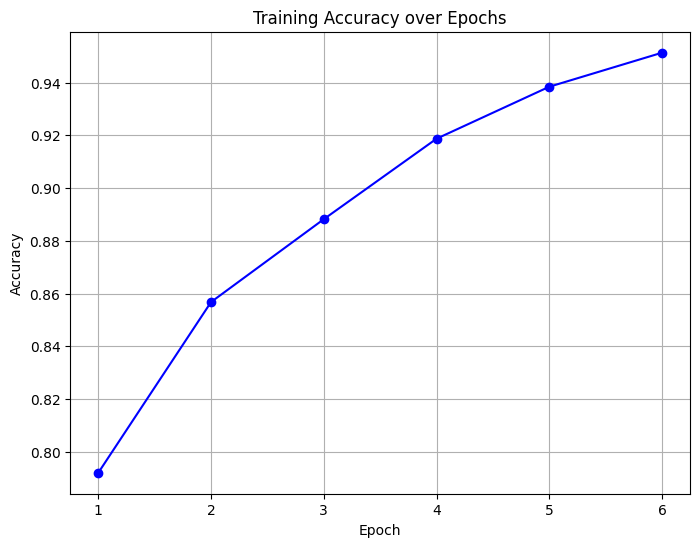

In [6]:
import matplotlib.pyplot as plt

epochs = range(1, 7)
training_acc = [0.7921, 0.8568, 0.8882, 0.9187, 0.9384, 0.9513]
training_loss = [0.4543, 0.3503, 0.2851, 0.2211, 0.1682, 0.1299]

# Plot the training accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_acc, marker='o', linestyle='-', color='blue')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid(True)
plt.show()

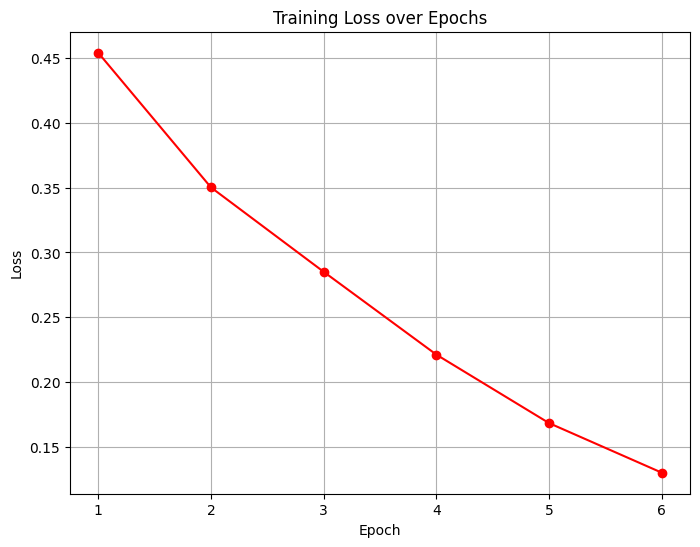

In [7]:
# Plot the training loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_loss, marker='o', linestyle='-', color='red')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)
plt.show()

### Prediciting on the Test Set

In [26]:
# Load test data
test_data = pd.read_csv('/content/drive/MyDrive/testD.csv')

In [27]:
# Combine text and keyword columns
test_data['text'] = test_data['text'] + ' ' + test_data['keyword'].fillna('')

In [28]:
# Preprocessing
test_data['text'] = test_data['text'].apply(preprocess_text)

In [29]:
# Tokenize the test data
input_ids_test = tokenizer(test_data['text'].tolist(), truncation=True, padding='max_length', max_length=78, return_tensors='tf')

# Prepare the test data
X_test = {
    'input_ids': input_ids_test['input_ids'],
    'attention_mask': input_ids_test['attention_mask']
}

In [30]:
# Generate predictions
predictions = modelLSTM.predict(X_test)

102/102 [==============================] - 7s 33ms/step


In [31]:
# Convert prediction probabilities to binary predictions
predictions_binary = [1 if pred >= 0.5 else 0 for pred in predictions]

In [32]:
# Create a DataFrame with id and target columns
submission_df = pd.DataFrame({'id': test_data['id'], 'target': predictions_binary})

# Save the DataFrame to CSV
submission_df.to_csv('DsubmissionLSTM.csv', index=False)

In [33]:
submission_df.head(5)

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [34]:
from google.colab import files
files.download('DsubmissionLSTM.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# RNN with GRU

### Model Training

In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GRU, Dense, Masking

In [36]:
# Tokenize the data
input_ids = tokenizer(train_data['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors='tf')

In [37]:
# Prepare the data
X_train = {'input_ids': input_ids['input_ids'], 'attention_mask': input_ids['attention_mask']}
y_train = train_data['target'].values

In [38]:
input_ids_in = Input(shape=(78,), name='input_ids', dtype='int32')
mask_in = Input(shape=(78,), name='attention_mask', dtype='int32')

In [39]:
# We access the transformer model within our bert_model
embedding_layer = bert_model.layers[0]
embeddings = embedding_layer(input_ids_in, attention_mask=mask_in)[0]

In [40]:
# Define the model architecture with GRU
def build_gru_model():
    embeddings = bert_model(input_ids_in, attention_mask=mask_in)[0]
    rnn_input = Masking(mask_value=0)(embeddings)
    rnn_output = GRU(units=64)(rnn_input)
    output = Dense(units=1, activation='sigmoid')(rnn_output)
    model = Model(inputs=[input_ids_in, mask_in], outputs=output)
    return model

In [41]:
# Build the model
modelGRU = build_gru_model()
modelGRU.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
modelGRU.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 78)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 78)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 78,                                          

In [43]:
# Train the model
modelGRU.fit(X_train, y_train, epochs=6, verbose=1)

Epoch 1/6


238/238 [==============================] - 80s 136ms/step - loss: 0.1488 - accuracy: 0.9481
Epoch 2/6
238/238 [==============================] - 21s 88ms/step - loss: 0.0937 - accuracy: 0.9658
Epoch 3/6
238/238 [==============================] - 20s 82ms/step - loss: 0.0718 - accuracy: 0.9750
Epoch 4/6
238/238 [==============================] - 19s 82ms/step - loss: 0.0616 - accuracy: 0.9749
Epoch 5/6
238/238 [==============================] - 19s 80ms/step - loss: 0.0511 - accuracy: 0.9806
Epoch 6/6
238/238 [==============================] - 19s 79ms/step - loss: 0.0526 - accuracy: 0.9786


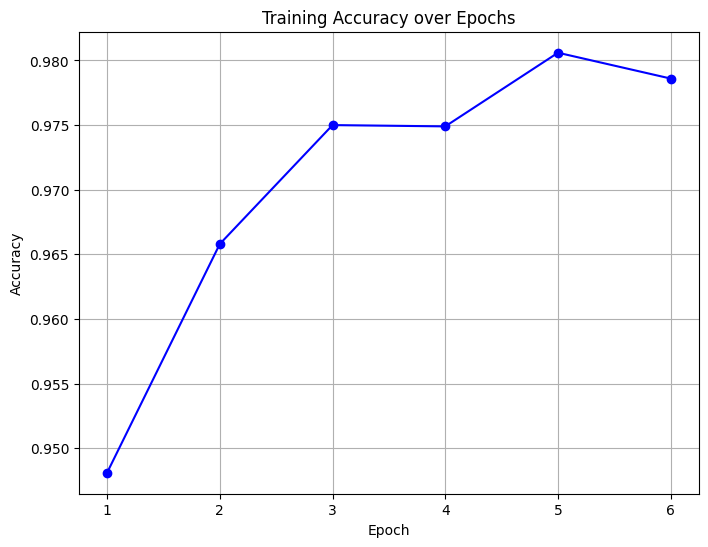

In [9]:
epochs = range(1, 7)
training_acc = [0.9481, 0.9658, 0.9750, 0.9749, 0.9806, 0.9786]
training_loss = [0.1488, 0.0937, 0.0718, 0.0616, 0.0511, 0.0526]

# Plot the training accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_acc, marker='o', linestyle='-', color='blue')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid(True)
plt.show()

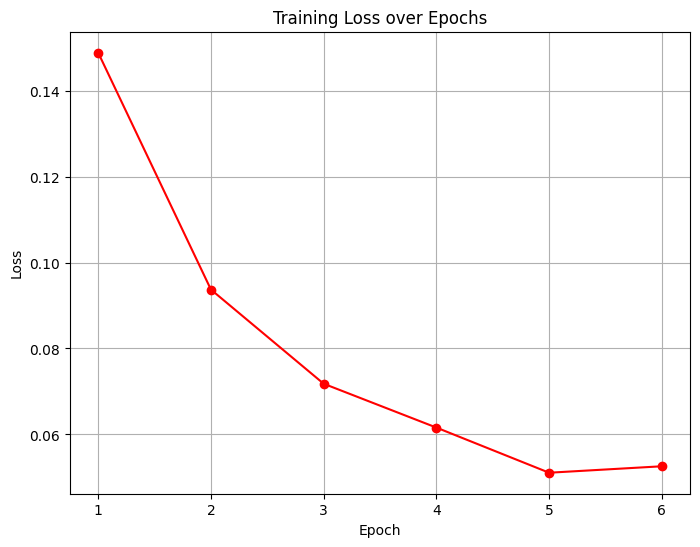

In [10]:
# Plot the training loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_loss, marker='o', linestyle='-', color='red')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)
plt.show()

### Predicting on the Test Set

In [44]:
# Load test data
test_data = pd.read_csv('/content/drive/MyDrive/testD.csv')

In [45]:
# Combine text and keyword columns
test_data['text'] = test_data['text'] + ' ' + test_data['keyword'].fillna('')

In [46]:
# Preprocessing
test_data['text'] = test_data['text'].apply(preprocess_text)

In [47]:
# Tokenize the test data
input_ids_test = tokenizer(test_data['text'].tolist(), truncation=True, padding='max_length', max_length=78, return_tensors='tf')

# Prepare the test data
X_test = {
    'input_ids': input_ids_test['input_ids'],
    'attention_mask': input_ids_test['attention_mask']
}

In [48]:
# Generate predictions
predictions = modelGRU.predict(X_test)

102/102 [==============================] - 7s 32ms/step


In [49]:
# Convert prediction probabilities to binary predictions
predictions_binary = [1 if pred >= 0.5 else 0 for pred in predictions]

In [50]:
# Create a DataFrame with id and target columns
submission_df = pd.DataFrame({'id': test_data['id'], 'target': predictions_binary})

# Save the DataFrame to CSV
submission_df.to_csv('DsubmissionGRU.csv', index=False)

In [51]:
submission_df.head(5)

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [52]:
from google.colab import files
files.download('DsubmissionGRU.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Bidirectional RNN

### Model Training

In [53]:
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Masking

In [54]:
# Tokenize the data
input_ids = tokenizer(train_data['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors='tf')

In [55]:
# Prepare the data
X_train = {'input_ids': input_ids['input_ids'], 'attention_mask': input_ids['attention_mask']}
y_train = train_data['target'].values

In [56]:
input_ids_in = Input(shape=(78,), name='input_ids', dtype='int32')
mask_in = Input(shape=(78,), name='attention_mask', dtype='int32')

In [57]:
# We access the transformer model within our bert_model
embedding_layer = bert_model.layers[0]
embeddings = embedding_layer(input_ids_in, attention_mask=mask_in)[0]

In [58]:
# Define the model architecture with Bidirectional RNN
def build_bidirectional_model():
    embeddings = bert_model(input_ids_in, attention_mask=mask_in)[0]
    rnn_input = Masking(mask_value=0)(embeddings)
    rnn_output = Bidirectional(LSTM(units=64))(rnn_input)
    output = Dense(units=1, activation='sigmoid')(rnn_output)
    model = Model(inputs=[input_ids_in, mask_in], outputs=output)
    return model

In [59]:
# Build and compile the Bidirectional LSTM model
bidirectional_model = build_bidirectional_model()
bidirectional_model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
bidirectional_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 78)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 78)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 78,                                          

In [61]:
# Train the Bidirectional LSTM model
bidirectional_model.fit(X_train, y_train, epochs=6, verbose=1)

Epoch 1/6


238/238 [==============================] - 86s 140ms/step - loss: 0.0851 - accuracy: 0.9725
Epoch 2/6
238/238 [==============================] - 22s 91ms/step - loss: 0.0481 - accuracy: 0.9815
Epoch 3/6
238/238 [==============================] - 21s 87ms/step - loss: 0.0428 - accuracy: 0.9828
Epoch 4/6
238/238 [==============================] - 20s 83ms/step - loss: 0.0432 - accuracy: 0.9841
Epoch 5/6
238/238 [==============================] - 20s 83ms/step - loss: 0.0347 - accuracy: 0.9858
Epoch 6/6
238/238 [==============================] - 20s 84ms/step - loss: 0.0330 - accuracy: 0.9862


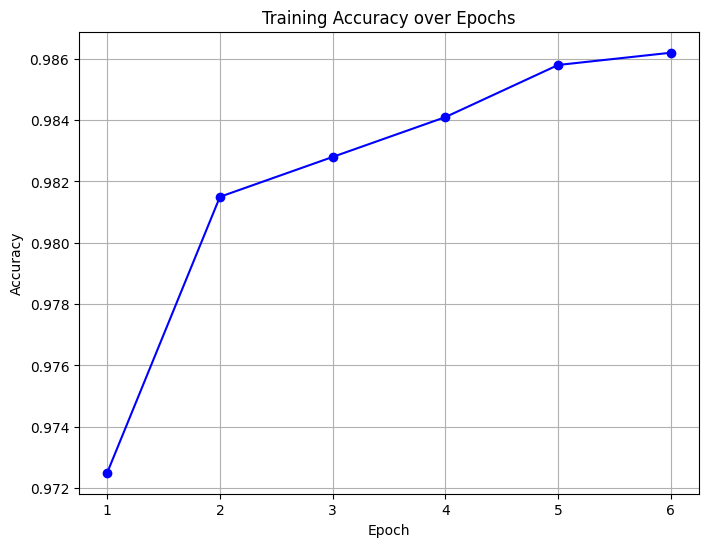

In [11]:
epochs = range(1, 7)
training_acc = [0.9725, 0.9815, 0.9828, 0.9841, 0.9858, 0.9862]
training_loss = [0.0851, 0.0481, 0.0428, 0.0432, 0.0347, 0.0330]

# Plot the training accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_acc, marker='o', linestyle='-', color='blue')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid(True)
plt.show()

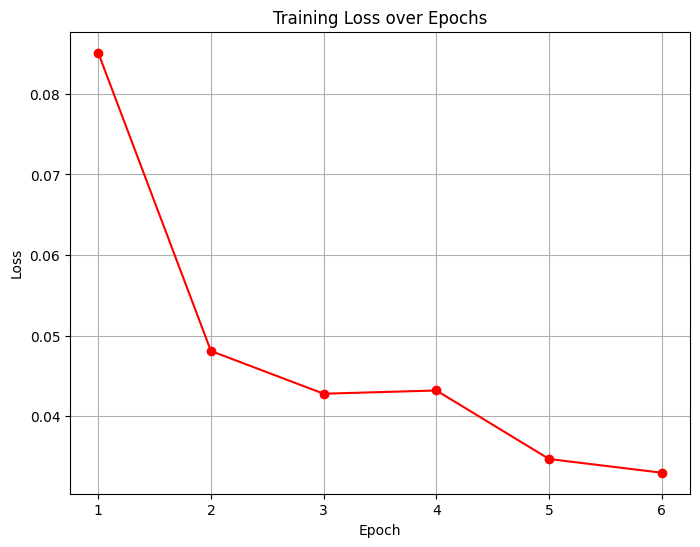

In [12]:
# Plot the training loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_loss, marker='o', linestyle='-', color='red')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)
plt.show()

### Predicting on the Test Set

In [62]:
# Load test data
test_data = pd.read_csv('/content/drive/MyDrive/testD.csv')

In [63]:
# Combine text and keyword columns
test_data['text'] = test_data['text'] + ' ' + test_data['keyword'].fillna('')

In [64]:
# Preprocessing
test_data['text'] = test_data['text'].apply(preprocess_text)

In [65]:
# Tokenize the test data
input_ids_test = tokenizer(test_data['text'].tolist(), truncation=True, padding='max_length', max_length=78, return_tensors='tf')

# Prepare the test data
X_test = {
    'input_ids': input_ids_test['input_ids'],
    'attention_mask': input_ids_test['attention_mask']
}

In [66]:
# Generate predictions
predictions = bidirectional_model.predict(X_test)

102/102 [==============================] - 9s 34ms/step


In [67]:
# Convert prediction probabilities to binary predictions
predictions_binary = [1 if pred >= 0.5 else 0 for pred in predictions]

In [68]:
# Create a DataFrame with id and target columns
submission_df = pd.DataFrame({'id': test_data['id'], 'target': predictions_binary})

# Save the DataFrame to CSV
submission_df.to_csv('DsubmissionBi.csv', index=False)

In [69]:
submission_df.head(5)

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [70]:
from google.colab import files
files.download('DsubmissionBi.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Results and Discussion

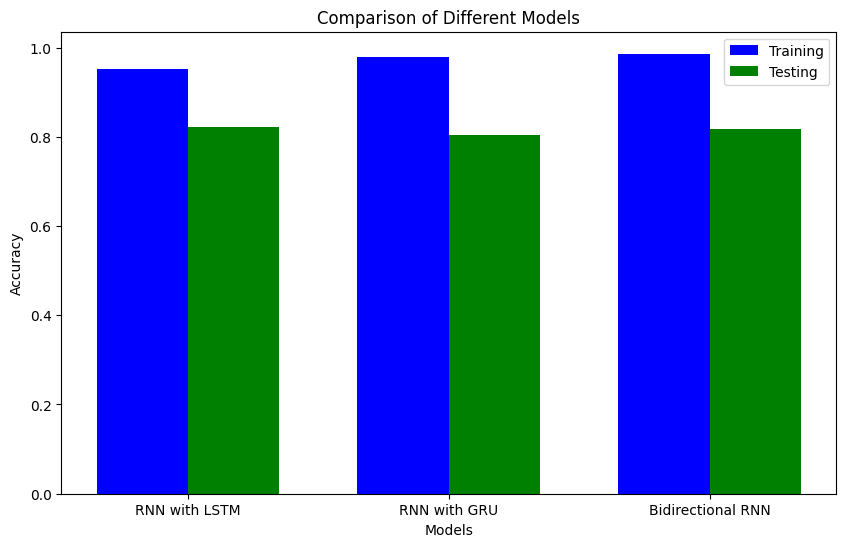

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Define data
models = ['RNN with LSTM', 'RNN with GRU', 'Bidirectional RNN']
training_accuracy = [0.9513, 0.9786, 0.9862]
testing_accuracy = [0.82102, 0.80508, 0.81673]

# Define bar width
bar_width = 0.35

# Create index
index = np.arange(len(models))

# Create plot
plt.figure(figsize=(10,6))

bar1 = plt.bar(index, training_accuracy, bar_width, label='Training', color='b')
bar2 = plt.bar(index + bar_width, testing_accuracy, bar_width, label='Testing', color='g')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Different Models')
plt.xticks(index + bar_width / 2, models)  # position x-axis labels in the center of the bars
plt.legend()

# Show plot
plt.show()

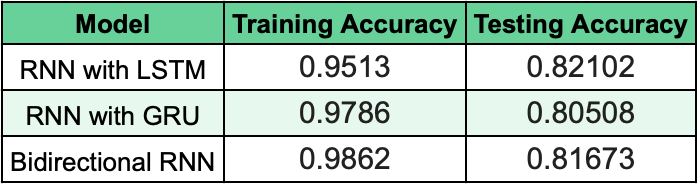

The testing accuracy scores are within an acceptable range at over 0.80. Notice that higher training accuracy does not always translate to higher accuracy. Bidirectional RNN while having a superior training accuracy at 0.9862 compared to RNN with LSTM at 0.9513, scored lower on the testing accuracy. This showcased that model complexity brought diminishing returns. A more advanced model might actually overfit the data and consequently have worse generalisability.

Further research should experiment with other language model transformer such as 'bert_large_uncased' where the total number of parameters are over 300 millions, compared to 109 million parameters in our case. Because of constrains in computing resources, our project could not utilize this more advanced language model. Configuring the structure of the models is also an options. Adding more dense layers might further overfit the data though, so one has to proceed with caution. Experimenting with different optimizer besides 'Adam', and other learning rates are also viable.